In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque
import json
import dateparser

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

import requests
import io

import os
import numpy as np
import pandas as pd
import random

In [4]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
import pandas as pd
import os
import time
from binance.client import Client
from datetime import timedelta, datetime
import pytz
import numpy as np

epoch = 0
fmt = "%Y-%m-%d %H:%M:%S"  # e.g. 2019-11-16 23:16:15
org_columns = ['open',
               'high', 'low', 'close', 'volume', 'close_time', 'quote_av',
               'trades', 'tb_base_av', 'tb_quote_av', 'ignore']

columns_of_interest = ['open', 'high', 'low', 'close', 'volume']


def init_mod():
    # refer: https://www.binance.com/en/support/articles/360002502072 for API keys
    binance_api_key = "9iEgiTeIeMW380ER30Th1rWpRC0s0xciUdHsq9cdtj54VIlqWDyq22pdpVnl2z5O"
    binance_api_secret = "q5m1Y6TwMFqkPm0qcHr9FTV7gwXOfu7coApGUUoFiTHsT1FKuuFqEhgF2K992L4q"
    binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)
    global epoch
    epoch = datetime.utcfromtimestamp(0)
    return binance_client


def convert_time_to_utc(pst_time):
    utc = pytz.utc
    pst = pytz.timezone('America/Los_Angeles')
    datetime1 = datetime.strptime(pst_time, fmt)
    pst_time = pst.localize(datetime1)
    return pst_time.astimezone(utc).strftime(fmt)


def convert_time_to_pst(utc_time):
    datetime_obj = datetime.strptime(utc_time, fmt)
    return datetime_obj.replace(tzinfo=time.timezone('UTC')).strftime(fmt)


def to_unixmillis(from_date):
    # from_date_obj = datetime.strptime(from_date, fmt)
    # past = datetime(1970, 1, 1, tzinfo=from_date_obj.tzinfo)
    return datetime.strptime(from_date, '%Y-%m-%d %H:%M:%S')


def to_datetime(ms):
    return datetime.fromtimestamp(int(float(ms) / 1000.0))


def download_data_from_binance(symbol, from_date, to_date, output_filename, step=0, pause=-1, simulate=False):
    """
    :param symbol:
    :param from_date:
    :param to_date:
    :param output_filename:
    :param step: step in number of days. Download data in batches of days given by 'step'
    :param pause: pause seconds before downloading next batch.
        if pause == -1 --> random sleep(2,5)
        if pause == 0 --> no sleep
        if pause == num--> sleep for num of seconds
    :param simulate:
    :return:
    """
    binance_client = init_mod()
    from_date_obj = datetime.strptime(from_date, fmt)
    step_date_obj = from_date_obj + timedelta(days=step)
    step_date = step_date_obj.strftime(fmt)

    from_millis = to_unixmillis(from_date)
    to_millis = to_unixmillis(to_date)
    step_millis = to_unixmillis(step_date)

    count = 0
    while True:
        from_millis_str = str(from_millis)
        step_millis_str = str(step_millis)
        print('Step %d:Downloading data from %s to %s' % (count,
                                                          str(from_millis_str),
                                                          str(step_millis_str)
                                                          ))
        if not simulate:
            # download data

            klines = binance_client.get_historical_klines(symbol, Client.KLINE_INTERVAL_1DAY,
                                                          from_millis_str, end_str=step_millis_str)
            klines_len = len(klines)
            if klines_len == 0:
                print('\t Failed to download from %s to %s. Got %d' % (str(to_datetime(from_millis_str)),
                                                                       str(to_datetime(step_millis_str)), klines_len
                                                                       ))
                time.sleep(5)

            # print('\t Downloaded data of len %d from %s to %s' % (klines_len,
            #                                                       str(from_millis_str),
            #                                                       str(step_millis_str)
            #                                                       ))
            new_columns = [item + '_' + symbol for item in org_columns]
            new_columns.insert(0, 'timestamp')

            data_df = pd.DataFrame(klines,
                                   columns=new_columns)
            data_df['timestamp'] = pd.to_datetime(data_df['timestamp'], unit='ms')
            data_df.set_index('timestamp', inplace=True)
            data_df.to_csv(output_filename)

        # move to next step of batches
        from_millis = step_millis
        step_date_obj = step_date_obj + timedelta(days=step)
        step_date = step_date_obj.strftime(fmt)
        step_millis = to_unixmillis(step_date)
        count = count + 1
        if pause == -1:
            pause = np.random.randint(2, 5)
        time.sleep(pause)
        if step_millis >= to_millis:
            break


def concat_binance_data(symbol_list, output_filename):
    df_list = []
    for num, symbol in enumerate(symbol_list):
        filename = str('%s-binance-data.csv' % (symbol))
        df = pd.read_csv(filename, index_col=0)
        df_list.append(df)

    result = pd.concat(df_list, axis=1, sort=True)
    result.index = pd.to_datetime(df.index)
    result = result.sort_index().drop_duplicates(keep='first')
    idx = np.unique(result.index, return_index=True)[1]
    result = result.iloc[idx]

    new_columns = [item + '_' + 'BTCUSDT' for item in columns_of_interest]
    # new_columns.insert(0, 'timestamp')

    for num, symbol in enumerate(symbol_list):
        if symbol == 'BTCUSDT':
            continue
        new_columns.append('close_' + symbol)
        new_columns.append('volume_' + symbol)

    result = result[new_columns]
    result.to_csv(output_filename)


def remove_dup_by_index(output_filename):
    result = pd.read_csv(output_filename, index_col=0)
    result.index = pd.to_datetime(result.index)
    result = result.sort_index()        #.drop_duplicates(keep='first')
    idx = np.unique(result.index, return_index=True)[1]
    result = result.iloc[idx]
    result.to_csv(output_filename)


def append_binance_data(master_output_filename, concat_output_filename):
    master_df = pd.read_csv(master_output_filename)
    new_df = pd.read_csv(concat_output_filename)
    master_df = master_df.append(new_df)
    master_df.set_index('timestamp', inplace=True)
    master_df.index = pd.to_datetime(master_df.index)
    master_df = master_df.sort_index().drop_duplicates(keep='first')
    master_df.to_csv(master_output_filename)

In [6]:
from_date = '2017-02-01 00:00:00'
to_date = '2025-02-04 00:00:00'
symbol_list = ['BTCUSDT']

In [7]:
to_date = time.strftime(fmt, time.localtime())

# UTC time is 8 hrs ahead of PST
for num, symbol in enumerate(symbol_list):
    output_filename = '%s-binance-data.csv' % (symbol)
    print('-' * 60)
    print('Downloading data from %s to %s for %s' % (from_date, to_date, symbol))
    print('-' * 60)
    download_data_from_binance(symbol, from_date, to_date, output_filename, step=365*5, pause=-1, simulate=False)

# concat all currency data
concat_output_filename = 'binance_BTCUSDT_day.csv'
concat_binance_data(symbol_list, concat_output_filename)

------------------------------------------------------------
------------------------------------------------------------
Step 0:Downloading data from 2017-02-01 00:00:00 to 2022-01-31 00:00:00


In [8]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the dataset (both training & testing), default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        split_by_date (bool): whether we split the dataset into training/testing by date, setting it 
            to False will split datasets in a random way
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # # see if ticker is already a loaded stock from yahoo finance
    # if isinstance(ticker, str):
    #     # load it from yahoo_fin library
    #     df = si.get_data(ticker)
    # elif isinstance(ticker, pd.DataFrame):
    #     # already loaded, use it directly
    #     df = ticker
    # else:
    #     raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")

    df = pd.read_csv('binance_BTCUSDT_day.csv')
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
    df.set_index('date', inplace = True)
    df.index = pd.to_datetime(df.index)

    # this will contain all the elements we want to return from this function
    result = {}

    # sp500 = si.get_data('^GSPC')
    # sp500.columns = ['open_sp500', 'high_sp500', 'low_sp500', 'close_sp500', 'adjclose_sp500', 'volume_sp500', 'ticker']
    # sp500['date'] = sp500.index

    # gc = si.get_data('GC=F')
    # gc.columns = ['open_gc', 'high_gc', 'low_gc', 'close_gc', 'adjclose_gc', 'volume_gc', 'ticker']
    # gc['date'] = gc.index

    # dxy = si.get_data('DX-Y.NYB')
    # dxy.columns = ['open_dxy', 'high_dxy', 'low_dxy', 'close_dxy', 'adjclose_dxy', 'volume_dxy', 'ticker']
    # dxy['date'] = dxy.index

    # df = df.merge(sp500[['open_sp500', 'high_sp500', 'low_sp500', 'close_sp500', 'adjclose_sp500', 'volume_sp500', 'date']], on='date', how = 'left', copy = False)
    # df = df.merge(gc[['open_gc', 'high_gc', 'low_gc', 'close_gc', 'adjclose_gc', 'volume_gc', 'date']], on='date', how = 'left', copy = False)
    # df = df.merge(dxy[['open_dxy', 'high_dxy', 'low_dxy', 'close_dxy', 'adjclose_dxy', 'volume_dxy', 'date']], on='date', how = 'left', copy = False)
    # df.index = df['date']

    # drop NaNs
    df.dropna(inplace=True)

    # remove the last data (as it's likely incomplete)
    df = df[:-1]

    # we will also return the original dataframe itself
    result['df'] = df.copy()
    
    # add percentage_change
    df['pct_change_1d'] = df['close'].pct_change(1)
    df['pct_change_7d'] = df['close'].pct_change(7)

    # add rolling averages
    df['rolling_3'] = df['close'].rolling(3).mean()
    df['rolling_5'] = df['close'].rolling(5).mean()
    df['rolling_10'] = df['close'].rolling(10).mean()
    df['rolling_25'] = df['close'].rolling(25).mean()
    df['rolling_50'] = df['close'].rolling(50).mean()
    df['rolling_100'] = df['close'].rolling(100).mean()

    # add typical price and Bollinger Bands
    df['typical_price'] = (df['close'] + df['low'] + df['high'])/3
    df['typical_std'] = df['typical_price'].rolling(20).std(ddof=0)
    df['BOLU'] = df['typical_price'].rolling(20).mean() + 2*df['typical_std']
    df['BOLD'] = df['typical_price'].rolling(20).mean() - 2*df['typical_std']

    # add RSI using SMA and EWM
    up, down = df['close'].diff().copy(), df['close'].diff().copy()
    up[up < 0] = 0
    down[down > 0] = 0

    window_length=14

    roll_up1 = up.rolling(window_length).mean()
    roll_down1 = down.rolling(window_length).mean().abs()

    rs_ma = roll_up1 / roll_down1
    df['rsi_ma'] = 100.0 - (100.0 / (1.0 + rs_ma))

    roll_up2 = up.ewm(span=window_length).mean()
    roll_down2 = down.abs().ewm(span=window_length).mean()

    rs_ewm = roll_up2 / roll_down2
    df['rsi_ewm'] = 100.0 - (100.0 / (1.0 + rs_ewm))

    # add MACD
    exp1 = df['close'].ewm(span=12, adjust=False).mean()
    exp2 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = exp1 - exp2

    # add Fear and Greed index
    url = 'https://api.alternative.me/fng/?limit=100000'
    fng = pd.json_normalize(requests.get(url).json(), 'data')
    fng['date'] = [pd.Timestamp(int(d), unit = 's').date().strftime('%Y-%m-%d') for d in fng['timestamp']]
    fng['date'] = pd.to_datetime(fng['date'])
    fng = fng[['value', 'date']]
    fng.columns = ['fng', 'date']
    df = df.merge(fng[['fng', 'date']], on = 'date')

    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."

    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler

    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['close'].shift(-lookup_step)

    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)

    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    result['df_scaled'] = df.copy()
    return result

In [9]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [10]:
import os
import time
from tensorflow.keras.layers import LSTM

# Window size or the sequence length
N_STEPS = 50
# Lookup step, 1 is the next day
LOOKUP_STEP = 1
# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ['open', 'high', 'low', 'close', 'volume', 'rolling_3', 'rolling_5', 'rolling_10', 'rolling_25', 'rolling_50', 'rolling_100', 'typical_price', 'typical_std', 'BOLU', 'BOLD', 'rsi_ma', 'rsi_ewm', 'macd', 'pct_change_1d', 'pct_change_7d', 'fng']
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 3
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = True
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 500
# BTC stock market
ticker = "BTC-USD"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [11]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [12]:
# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)

In [13]:
data['df_scaled']

,date,open,high,low,close,volume,pct_change_1d,pct_change_7d,rolling_3,rolling_5,...,rolling_100,typical_price,typical_std,BOLU,BOLD,rsi_ma,rsi_ewm,macd,fng,future
0,2018-02-01,0.130504,0.128159,0.106930,0.110944,0.079972,0.494454,0.333857,0.125916,0.141133,...,0.288088,0.115512,0.173441,0.183450,0.196400,0.376722,0.232889,0.071972,0.277778,0.104458
1,2018-02-02,0.110936,0.108459,0.092768,0.104458,0.120920,0.604571,0.305284,0.117361,0.129495,...,0.289272,0.102037,0.169143,0.177528,0.189512,0.316274,0.209087,0.057667,0.111111,0.110491
2,2018-02-03,0.104451,0.112508,0.096954,0.110491,0.067893,0.731515,0.305802,0.110558,0.121557,...,0.290513,0.106795,0.164724,0.172447,0.184189,0.215129,0.278265,0.052136,0.388889,0.091760
3,2018-02-04,0.110483,0.110601,0.091239,0.091760,0.076103,0.482217,0.179571,0.104039,0.113613,...,0.291411,0.098013,0.155774,0.165729,0.179649,0.225139,0.202997,0.037480,0.211111,0.068791
4,2018-02-05,0.091665,0.092713,0.066297,0.068791,0.154442,0.411510,0.098034,0.091919,0.100667,...,0.291865,0.076137,0.191742,0.170531,0.159118,0.207042,0.140650,0.013091,0.066667,0.081931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,2021-02-17,0.847255,0.895889,0.875183,0.902414,0.210198,0.772052,0.715670,0.874655,0.884280,...,0.927457,0.891373,0.932849,0.904858,0.845936,0.837741,0.857403,0.852012,1.000000,0.891950
1110,2021-02-18,0.902313,0.894278,0.912546,0.891950,0.147840,0.650679,0.615630,0.897487,0.901304,...,0.940935,0.899412,0.958472,0.925914,0.862114,0.842259,0.809909,0.868213,0.955556,0.972276
1111,2021-02-19,0.891888,0.963963,0.908882,0.972276,0.195014,0.812138,0.737222,0.939950,0.929666,...,0.955888,0.948917,0.987638,0.951004,0.882490,0.864960,0.887117,0.925543,0.977778,0.971080
1112,2021-02-20,0.972208,0.988156,0.969159,0.971080,0.198230,0.667145,0.739464,0.963283,0.960357,...,0.970591,0.976278,0.998818,0.974015,0.913696,0.856372,0.882040,0.961558,0.955556,1.000000


In [14]:
# save the dataframe
data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

1

Epoch 00279: val_loss did not improve from 0.00005
Epoch 280/500
14/14 [==============================] - 1s 38ms/step - loss: 1.3247e-04 - mean_absolute_error: 0.0102 - val_loss: 1.0838e-04 - val_mean_absolute_error: 0.0106

Epoch 00280: val_loss did not improve from 0.00005
Epoch 281/500
14/14 [==============================] - 1s 38ms/step - loss: 1.2525e-04 - mean_absolute_error: 0.0103 - val_loss: 1.7693e-04 - val_mean_absolute_error: 0.0119

Epoch 00281: val_loss did not improve from 0.00005
Epoch 282/500
14/14 [==============================] - 1s 38ms/step - loss: 1.5034e-04 - mean_absolute_error: 0.0118 - val_loss: 1.0903e-04 - val_mean_absolute_error: 0.0097

Epoch 00282: val_loss did not improve from 0.00005
Epoch 283/500
14/14 [==============================] - 1s 38ms/step - loss: 1.2419e-04 - mean_absolute_error: 0.0104 - val_loss: 1.4885e-04 - val_mean_absolute_error: 0.0088

Epoch 00283: val_loss did not improve from 0.00005
Epoch 284/500
14/14 [=====================

In [15]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_close_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'close_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.xticks(rotation=45)
    plt.show()

In [16]:
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, true_future, pred_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, true_future, pred_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["close"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["close"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"close_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_close_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["close"], 
                                    final_df[f"close_{LOOKUP_STEP}"], 
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["close"], 
                                    final_df[f"close_{LOOKUP_STEP}"], 
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [17]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["close"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [18]:
# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [19]:
# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["close"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [20]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

In [21]:
# predict the future price
future_price = predict(model, data)

In [22]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [23]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 1 days is 58095.73$
huber_loss loss: 5.164961112313904e-05
Mean Absolute Error: 3546.1940090266335
Accuracy score: 0.5727699530516432
Total buy profit: 1469.7174511718713
Total sell profit: 19342.69782226562
Total profit: 20812.415273437495
Profit per trade: 97.71086982834504


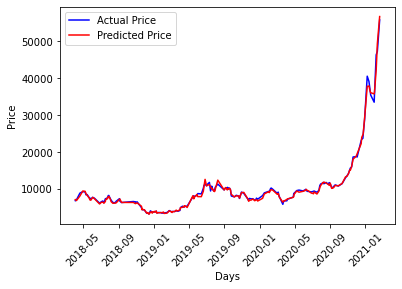

In [24]:
# plot true/pred prices graph
plot_graph(final_df)

In [25]:
data['df']

,open,high,low,close,volume
date,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060
...,...,...,...,...,...
2021-02-18,52117.67,52530.00,50901.90,51552.60,60758.046954
2021-02-19,51552.61,56368.00,50710.20,55906.00,79659.778020
2021-02-20,55906.00,57700.46,53863.93,55841.19,80948.205314


In [30]:
final_df.tail(10)

,open,high,low,close,volume,close_1,true_close_1,buy_profit,sell_profit
date,,,,,,,,,
2020-12-29,27079.42,27410.00,25880.00,27385.00,69411.592606,29289.671875,28875.54,1904.671875,0.000000
2021-01-07,36769.36,40365.00,36300.00,39432.28,132825.700437,37832.089844,40582.81,-1600.190156,0.000000
2021-01-13,34049.15,37850.00,32380.00,37371.38,124477.914938,37910.945312,39144.50,539.565313,0.000000
2021-01-17,35994.98,36852.50,33850.00,35828.61,80157.727384,36505.378906,36631.27,676.768906,0.000000
2021-01-19,36622.46,37850.00,35844.06,35891.49,79611.307769,36097.277344,35468.23,0.000000,-205.787344
2021-01-31,34262.89,34342.69,32171.67,33092.98,68742.280384,35780.570312,33526.37,2687.590312,0.000000
2021-02-01,33092.97,34717.27,32296.16,33526.37,82718.276882,36163.988281,35466.24,2637.618281,0.000000
2021-02-07,39181.01,39700.00,37351.00,38795.69,84363.679763,42264.355469,46374.87,3468.665469,0.000000
2021-02-11,44807.58,48678.90,43994.02,47969.51,89561.081454,49378.644531,47287.60,0.000000,-1409.134531
